In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import modelutils_v2 as modelutils

In [2]:
# class Critic(Model):
#   def __init__(self):
#     super(MyModel, self).__init__()
#     self.conv1 = Conv2D(32, 3, activation='relu')
#     self.flatten = Flatten()
#     self.d1 = Dense(128, activation='relu')
#     self.d2 = Dense(10)

#   def call(self, x):
#     x = self.conv1(x)
#     x = self.flatten(x)
#     x = self.d1(x)
#     return self.d2(x)

# class Actor(Model):
#   def __init__(self):
#     super(MyModel, self).__init__()
#     self.conv1 = Conv2D(32, 3, activation='relu')
#     self.flatten = Flatten()
#     self.d1 = Dense(128, activation='relu')
#     self.d2 = Dense(10)

#   def call(self, x):
#     x = self.conv1(x)
#     x = self.flatten(x)
#     x = self.d1(x)
#     return self.d2(x)

# # Create an instance of the model
# critic_target = Critic()
# critic_raw = Critic()

# actor_target = Actor()
# actor_raw = Actor()

In [3]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

# # Add a channels dimension
# x_train = x_train[..., tf.newaxis].astype("float32")
# x_test = x_test[..., tf.newaxis].astype("float32")

In [4]:
# train_ds = tf.data.Dataset.from_tensor_slices(
#     (x_train, y_train)).shuffle(10000).batch(32)

# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [5]:
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adam()

In [6]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [7]:
# @tf.function
# def train_step(images, labels):
#   with tf.GradientTape() as tape:
#     # training=True is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = model(images, training=True)
#     loss = loss_object(labels, predictions)
#   gradients = tape.gradient(loss, model.trainable_variables)
#   optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#   train_loss(loss)
#   train_accuracy(labels, predictions)

In [8]:
# @tf.function
# def test_step(images, labels):
#   # training=False is only needed if there are layers with different
#   # behavior during training versus inference (e.g. Dropout).
#   predictions = model(images, training=False)
#   t_loss = loss_object(labels, predictions)

#   test_loss(t_loss)
#   test_accuracy(labels, predictions)

In [9]:
# EPOCHS = 5

# for epoch in tqdm(range(EPOCHS)):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   train_accuracy.reset_states()
#   test_loss.reset_states()
#   test_accuracy.reset_states()

#   for images, labels in train_ds:
#     train_step(images, labels)

#   for test_images, test_labels in test_ds:
#     test_step(test_images, test_labels)

#   template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
#   print(template.format(epoch + 1,
#                         train_loss.result(),
#                         train_accuracy.result() * 100,
#                         test_loss.result(),
#                         test_accuracy.result() * 100))

In [10]:
#def reward(s):
"""
returns the reward associated with state s

"""

#def rl_sim(s_t,a_t):
"""
s_t is the state of the environment at time t

s_t is composed of...
agent_locations [96,npeople,nlocations]; a matrix describing 

a_t is the action of the actor at time t

"""

'\ns_t is the state of the environment at time t\n\ns_t is composed of...\nagent_locations [96,npeople,nlocations]; a matrix describing \n\na_t is the action of the actor at time t\n\n'

In [11]:
# class state:
    
#     def __init__(self,home_locations,lambda_=1e-2):
#         """
#         instantiates a state object. home_locations is an nlocations x npeople matrix describing the location that each person hangs around. we assume everyone eats lunch at chandler.
        
#         """
#         self.lambda_ = lambda_
#         self.npeople = home_locations.shape[-1]
        
#         #instantiate counters to hold number of tests and days left in quarantine
#         self.home_locations = home_locations
#         self.test_counter = np.zeros(home_locations.shape[-1])
#         self.quarantine_counter = np.zeros(home_locations.shape[-1])
        
#         self.exposures = np.zeros(shape=self.npeople)
        
#         #instantiate disease states; 11xN
#         self.disease_states = modelutils.gen_initstate(N=home_locations.shape[-1])
        
#         #instantiate a list holding transition matrices for location Markov Chain
#         self.loc_tmats = [modelutils.loc_tmat(np.where(home_locations[:,x]==1)[0],home_locations.shape[0]) for x in range(home_locations.shape[-1])]
        
#         #instantiate a location tensor; purely a placeholder when instantiated for the first time. 96 x nlocations x npeople
#         self.locations = np.zeros([96,home_locations.shape[1]+2,home_locations.shape[-1]])  #adding two "columns" for Chandler and Quarantine.
        
        
#     def move_agents(self):
#         """
#         generates a new location matrix based on loc_tmats,quarantine_counter,
            
#         Chandler is always index -2, Quarantine is index -1
            
#         return_shape 96 x nlocations x npeople
#         """
#         returnmat = np.zeros(self.locations.shape)
#         lunchtimes = modelutils.get_lunchtimes(npeople=self.npeople)

#         #write initial locations
#         returnmat[0,:-2,:] = self.home_locations
        
#         #now on to the main loop
#         for time_idx in range(1,96):
#             for person_idx in range(self.npeople):
#                 locmat = self.loc_tmats[person_idx]
#                 returnmat[time_idx,np.random.choice(np.arange(self.home_locations.shape[1]),p=np.squeeze(locmat[np.where(returnmat[time_idx-1,:,person_idx]==1)[0],:])),person_idx]=1.
        
#         #write lunch into the returnmatrix
#         for x in range(len(lunchtimes[0][0])):
#             returnmat[lunchtimes[0][0][x]:lunchtimes[1][0][x],:,x] = 0 #overwriting all locations in lunch, we need to erase first
#             returnmat[lunchtimes[0][0][x]:lunchtimes[1][0][x],-2,x] = 1.  #middle 0 index is because the arrays come packed in lists...not the best idea admittedly.
        
#         #finally, do exclusion by quarantine
#         quarantine_indices = np.where(self.quarantine_counter!=0)[0]  #grab everyone in quarantine
#         returnmat[:,:,quarantine_indices]=0  #erase their locations
#         returnmat[:,-1,quarantine_indices]=1.  #and shove them in quarantine
        
#         return returnmat
        
#     def get_exposures(self):
#         """
#         uses locations, disease_state and quarantine_counter to calculate the exposures for each person.
            
#         returns a vector npeople long
#         """
#         returnvec = np.zeros(self.npeople)
        
#         infected_people = list(np.where(self.disease_states[6,:]==1.)[0])
#         infected_people += list(np.where(self.disease_states[7,:]==1.)[0])
#         infected_people += list(np.where(self.disease_states[8,:]==1.)[0])
        
#         #main loop
#         for person_idx in range(self.npeople):
#             for time_idx in range(96):
#                 current_location = np.where(self.locations[time_idx,:,person_idx]==1.)[0][0]
                
#                 people_at_location = list(np.where(self.locations[time_idx,current_location,:]==1.)[0])
                
#                 returnvec[person_idx]+= len([x for x in people_at_location if x in infected_people])
                
#             #in case the person is in quarantine, set their exposure to 0
#             if current_location==self.locations.shape[1]-1:
#                 returnvec[person_idx] = 0
#         return returnvec
    
#     def update_disease_state(self):
#         """
#         updates disease state; based on the cum_transmission function
#         """
#         returnmat = np.zeros([11,self.npeople])
#         pse = 1.-np.exp(-self.lambda_*self.exposures)
        
#         for person_idx in range(self.npeople):
#             tmat = modelutils.state_tmat(pse[person_idx])
#             returnmat[np.random.choice(np.arange(11),p=np.squeeze(tmat[np.where(self.disease_states[:,person_idx]==1)[0][0],:])),person_idx]=1.
#         return returnmat
    
#     def update_state(self,action):
#         """
#         action is a vector npeople long, with ones on people that we're going to test
        
#         returns another instance of state, at t+1
#         """
#         #instantiate output object
#         output_state = state(self.home_locations)
        
        
        
#         #record the action in test_counter
#         self.test_counter+=action
#         output_state.test_counter = self.test_counter
        
#         #look at results of test
#         test_indices = np.where(action==1)[0]
#         for test_idx in test_indices:
#             if np.sum(self.disease_states[6:9,test_idx])>0:  #check if the person is infected
#                 self.quarantine_counter[test_idx]+=15. #it's 15 because we're going to subtract one at the end

#         self.locations = self.move_agents()
#         self.exposures = self.get_exposures()
#         output_state.disease_states = self.update_disease_state()
        
#         self.quarantine_counter += -1
#         self.quarantine_counter = np.maximum(np.zeros(self.npeople),self.quarantine_counter)  #don't let people quarantine themselves negative days
#         output_state.quarantine_counter = self.quarantine_counter
        
#         return output_state
        
            
npeople = 20
tsteps = 14
ax=None
ntrials = 5
action = None
init_state = modelutils.state(np.eye(npeople)) 

Trial:  4


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9a1d566890>)

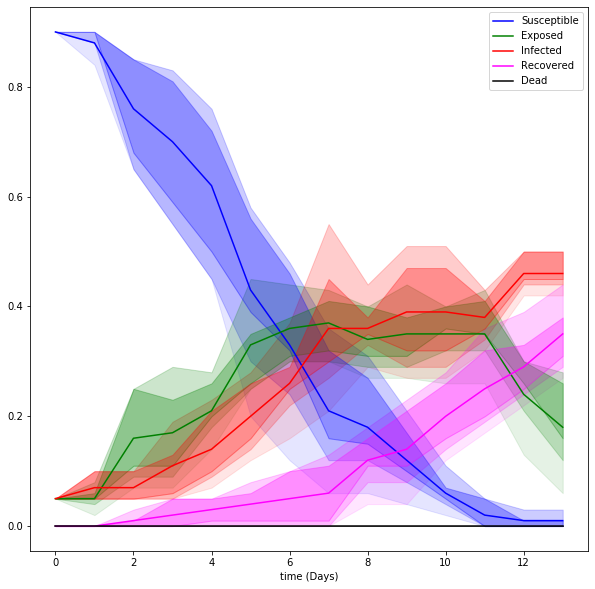

In [12]:
tseries_list = modelutils.gen_tseries_list(init_state,tsteps,ntrials,action)
percentiles = modelutils.gen_percentiles(tseries_list)
modelutils.plot_percentiles(percentiles,tseries_list)

Trial:  9


(2, 5)